AI-Powered E-Payment Fraud Detection System

Project Title: Developing an Adaptive Machine Learning System for Real-time E-Payment Fraud Detection in a Smart Nation Context

Progress Check
Model Development
You should have evaluated the suitablity of the data and finalized on the dataset. You are expected to perform extensive Exploratory Data Analysis to gain understanding of the data, and performed data cleaning, transformaion and feature engineering. You will work closely with MLOps team to help setup common data pipeline to be used in development and production. A baseline model should have been developed and early experimental results documented, and error analysis performed. You shoud log all the experiments using the experiment tracking facility setup by MLOps team.

Credit Card Fraud Detection Dataset https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data

PaySim Mobile Money Dataset https://www.kaggle.com/datasets/ealaxi/paysim1

Financial Fraud Detection Dataset https://www.kaggle.com/datasets/sriharshaeedala/financial-fraud-detection-dataset

# 1) Exploratory Data Analysis (EDA)

In this section, we explore the `Synthetic_Financial_datasets_log.csv` dataset to gain a deep understanding of its structure, content, and key characteristics before modeling.  
We will:
- Inspect dataset shape, data types, and sample records
- Check for missing values and duplicates
- Analyse the distribution of features and the target variable (`Class`)
- Identify correlations between features and the target
- Explore temporal patterns and outliers

This step ensures we understand the dataset well enough to perform effective cleaning, transformation, and feature engineering in later stages.


In [1]:
!pip install gradio
!pip install -U xgboost

In [2]:
# --- Consolidated Imports ---
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import gradio as gr
import xgboost as xgb

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV

from xgboost import XGBClassifier
from xgboost import callback as xgb_cb

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    classification_report, precision_recall_curve, roc_curve
)

warnings.filterwarnings('ignore')
print("Imports ready.")

Imports ready.


In [3]:
# Read the CSV file into a DataFrame
df = pd.read_csv('Synthetic_Financial_datasets_log.csv')
df.shape

(6362620, 11)

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
# --- Missing Values ---
missing = df.isna().sum()
print("\nMissing values per column:\n", missing[missing > 0])


Missing values per column:
 Series([], dtype: int64)


In [7]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [8]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [9]:
# --- Duplicate Rows ---
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

Duplicate rows: 0


In [10]:
# Define features and target
target = "isFraud"            # <- actual label in your CSV
y = pd.to_numeric(df[target], errors="coerce").fillna(0).astype("int8")
X = df.drop(columns=[target])

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(f"Target: {target} | X: {X.shape} | Fraud rate: {y.mean():.4%}")


Target: isFraud | X: (6362620, 10) | Fraud rate: 0.1291%


### Feature Signals — Exploratory Correlation
To explore which raw features might align with fraud, we ranked numeric features by absolute Pearson correlation with the label on the training split.  
This is only indicative — correlation is weak due to anonymized/engineered features, but confirms that `amount`, `isFlaggedFraud`, and balance-related features carry some signal.


In [11]:
# === Top features by |correlation| with label (TRAIN ONLY) ===
import pandas as pd

# ycol: your label name (e.g., "isFraud" or "Class")
# Assumes X_train, y_train already exist
tmp = X_train.copy()
tmp["_label_"] = pd.Series(y_train).astype(int).values

corr = (tmp.corr(numeric_only=True)["_label_"]
          .drop(index="_label_", errors="ignore")
          .abs()
          .sort_values(ascending=False))

TOP_K = 15
print("Top features by |corr| (train-only):")
print(corr.head(TOP_K).round(4))


Top features by |corr| (train-only):
amount            0.0771
isFlaggedFraud    0.0493
step              0.0320
oldbalanceOrg     0.0103
newbalanceOrig    0.0080
oldbalanceDest    0.0058
newbalanceDest    0.0006
Name: _label_, dtype: float64


### Baseline — Dummy Classifier

- **What it does:** Always predicts the majority class (non-fraud).
- **Purpose:** Zero-skill baseline to show why accuracy is misleading on imbalanced data.
- **Expected:** Accuracy ≈ 1.0 (since almost all non-fraud), but **fraud recall & F1 = 0**.


### Dummy Baseline
**Hypothesis:**  
Always predicting the majority class will give high accuracy, but fail to detect fraud.  

**What we tried:**  
- DummyClassifier(strategy="most_frequent") as a sanity check.


In [12]:
# =========================
# Baseline: Dummy Classifier (Most Frequent)
# =========================

dmy = DummyClassifier(strategy="most_frequent", random_state=42).fit(X_train, y_train)
y_pred_dummy = dmy.predict(X_test)  # <--- keep consistent variable name
pr_auc = average_precision_score(y_test, dmy.predict_proba(X_test)[:, 1])

print("=== Dummy Baseline ===")
print(classification_report(y_test, y_pred_dummy, zero_division=0, digits=4))
print(f"PR-AUC (fraud) = {pr_auc:.6f} (≈ fraud rate in data)")


=== Dummy Baseline ===
              precision    recall  f1-score   support

           0     0.9987    1.0000    0.9994   1270881
           1     0.0000    0.0000    0.0000      1643

    accuracy                         0.9987   1272524
   macro avg     0.4994    0.5000    0.4997   1272524
weighted avg     0.9974    0.9987    0.9981   1272524

PR-AUC (fraud) = 0.001291 (≈ fraud rate in data)


### Leakage Check
Flag any features extremely correlated with the label (|corr| > 0.90). Such fields may encode target information and should be removed or justified.


In [13]:
corrs = df.corr(numeric_only=True)["isFraud"].drop("isFraud").abs()
print("Max correlation with label:", corrs.max().round(3))


Max correlation with label: 0.077


### Transaction Amount Patterns
We compare transaction amounts between fraud and non-fraud cases, using a log scale to account for skew.

Fraud transactions have much higher amounts (median and upper percentiles) than non-fraud; on log scale, the boxes are still separated, indicating strong skew and larger typical values for fraud.

               n        mean     median         p90          p99          max
isFraud                                                                      
0        6354407   178197.04   74684.72   364373.44   1586064.17  92445516.64
1           8213  1467967.30  441423.44  4521723.51  10000000.00  10000000.00


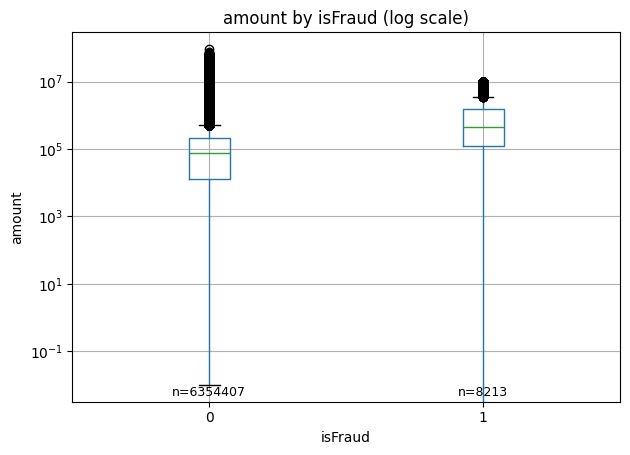

Median(amount) fraud / non-fraud ≈ 5.91x


In [14]:
# Boxplot by class (log y) + richer stats

label_col = "isFraud"
amount_col = "amount"

# Summary table with n, mean, median, p90, p99, max
summ = (df.groupby(label_col)[amount_col]
          .agg(n='size',
               mean='mean',
               median='median',
               p90=lambda s: np.percentile(s, 90),
               p99=lambda s: np.percentile(s, 99),
               max='max')
          .round(2))
print(summ)

# Boxplot (log scale)
ax = df[[amount_col, label_col]].boxplot(by=label_col, return_type='axes')[amount_col]
ax.set_yscale("log")
ax.set_title(f"{amount_col} by {label_col} (log scale)")
ax.figure.suptitle("")
ax.set_xlabel(label_col)
ax.set_ylabel(amount_col)

# Annotate n under each box (helps the reader)
ymin, ymax = ax.get_ylim()
for tick, (cls, row) in zip(ax.get_xticks(), summ.iterrows()):
    ax.text(tick, ymin*1.2, f"n={int(row['n'])}", ha='center', va='bottom', fontsize=9)

plt.tight_layout(); plt.show()

# Optional: a quick effect-size style note
if {0,1}.issubset(set(summ.index)):
    ratio = (summ.loc[1, 'median'] / summ.loc[0, 'median']) if summ.loc[0, 'median'] else np.nan
    print(f"Median(amount) fraud / non-fraud ≈ {ratio:.2f}x")


### Temporal Patterns
Fraud is not uniformly distributed by time: in this dataset, fraud rate spikes during early hours while transaction volume is low. This suggests time-derived features could carry signal.


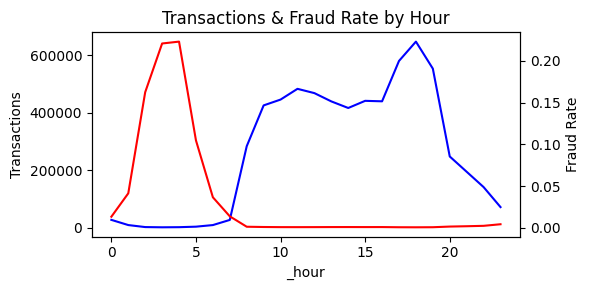

In [15]:
# For Kaggle synthetic logs

df["_hour"] = ((df["step"] - 1) % 24).astype(int)
hourly = df.groupby("_hour")["isFraud"].agg(transactions="size", fraud_rate="mean")

fig, ax1 = plt.subplots(figsize=(6,3))
hourly["transactions"].plot(ax=ax1, label="Transactions", color="blue")
ax1.set_ylabel("Transactions")
ax2 = ax1.twinx()
hourly["fraud_rate"].plot(ax=ax2, label="Fraud Rate", color="red")
ax2.set_ylabel("Fraud Rate")

plt.title("Transactions & Fraud Rate by Hour")
plt.tight_layout(); plt.show()
df.drop(columns=["_hour"], inplace=True)


### Correlation Matrix — Top Features vs Fraud Label
Compute a Spearman correlation matrix for the label and the **top-K** numeric features (selected by absolute correlation with the label on the full dataset). Use this to spot clusters and redundant features.  



Detected target column: isFraud


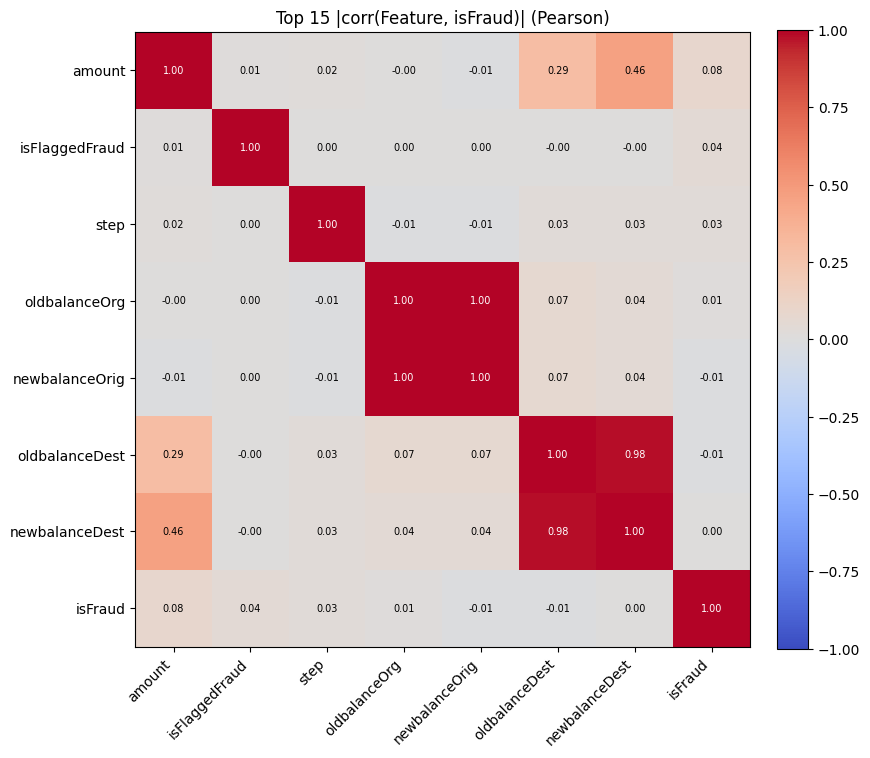

Saved: correlation_topk_vs_target.csv


In [16]:
# === Detect target column safely ===

# Lowercase mapping of all columns
lower = {c.lower(): c for c in df.columns}

# Common target column names in fraud datasets
candidates = ["class", "isfraud", "label", "target", "outcome", "y"]

target = None
for cand in candidates:
    if cand in lower:
        target = lower[cand]
        break

if target is None:
    raise ValueError(f"No target column found. Checked: {candidates}")

print("Detected target column:", target)

# Ensure target is numeric
if not pd.api.types.is_numeric_dtype(df[target]):
    df[target] = pd.to_numeric(df[target], errors="coerce").fillna(0).astype("int8")

# Keep only numeric columns
num = df.select_dtypes(include=[np.number]).copy()

# Absolute correlation with target
c_with_y = (
    num.drop(columns=[target], errors="ignore")
       .corrwith(num[target])
       .abs()
       .sort_values(ascending=False)
)

TOP_K = 15
top_feats = list(c_with_y.head(TOP_K).index)

# Correlation matrix for top features + target
cols = top_feats + [target]
cm = num[cols].corr().round(2)

# --- Plot heatmap ---
size = max(6, min(len(cols) * 0.6 + 4, 14))
fig, ax = plt.subplots(figsize=(size, size))
im = ax.imshow(cm, vmin=-1, vmax=1, cmap="coolwarm")

ax.set_xticks(range(len(cols))); ax.set_xticklabels(cols, rotation=45, ha="right")
ax.set_yticks(range(len(cols))); ax.set_yticklabels(cols)
ax.set_title(f"Top {TOP_K} |corr(Feature, {target})| (Pearson)")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        val = cm.iloc[i, j]
        ax.text(j, i, f"{val:.2f}", ha='center', va='center',
                fontsize=7, color=('white' if abs(val)>0.5 else 'black'))

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()

cm.to_csv("correlation_topk_vs_target.csv")
print("Saved: correlation_topk_vs_target.csv")


### Transaction Type — Volume & Fraud Rate
Group transactions by `type` and report volume, number of frauds, and fraud rate.  
We show two views: **Top by volume** and **Top by risk (fraud rate)**.  
Use this to decide whether `type` should be one-hot encoded and whether some types warrant separate thresholds or rules.


By risk (highest fraud rate first):
          transactions  frauds  fraud_rate
type                                      
TRANSFER        532909    4097      0.0077
CASH_OUT       2237500    4116      0.0018
CASH_IN        1399284       0      0.0000
DEBIT            41432       0      0.0000
PAYMENT        2151495       0      0.0000 

Top by volume:
          transactions  frauds  fraud_rate
type                                      
CASH_OUT       2237500    4116      0.0018
PAYMENT        2151495       0      0.0000
CASH_IN        1399284       0      0.0000
TRANSFER        532909    4097      0.0077
DEBIT            41432       0      0.0000 



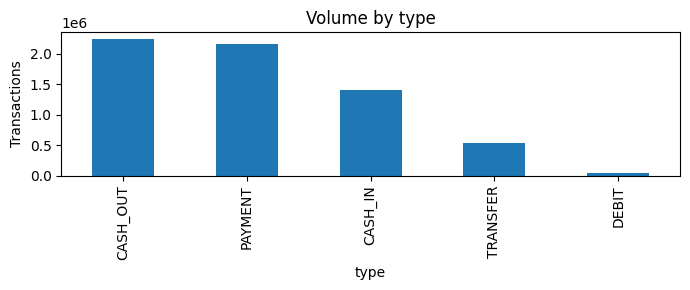

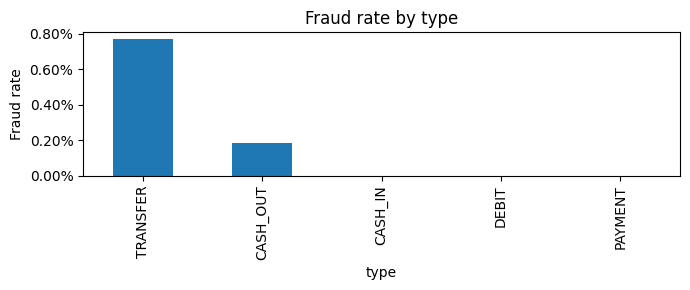

,transactions,frauds,fraud_rate,fraud_rate(%)
type,,,,
TRANSFER,532909,4097,0.007688,0.77
CASH_OUT,2237500,4116,0.001840,0.18
CASH_IN,1399284,0,0.000000,0.00
DEBIT,41432,0,0.000000,0.00
PAYMENT,2151495,0,0.000000,0.00


In [17]:
df = df.copy()
df.columns = [c.strip() if isinstance(c, str) else c for c in df.columns]

# detect columns inline
lower = {c.lower(): c for c in df.columns if isinstance(c, str)}
ycol = next((lower[k] for k in ["isfraud","class","label","target","outcome","y"] if k in lower), None)
typ  = next((lower[k] for k in ["type"] if k in lower), None)

assert ycol is not None, "Couldn't detect label column."
df[ycol] = pd.to_numeric(df[ycol], errors="coerce").fillna(0).astype(int)

if typ:
    base = (df.groupby(typ)[ycol]
              .agg(transactions="size", frauds="sum", fraud_rate="mean"))

    # Two sorted views
    by_risk = base.sort_values("fraud_rate", ascending=False)
    by_vol  = base.sort_values("transactions", ascending=False)

    print("By risk (highest fraud rate first):")
    print(by_risk.round(4), "\n")

    print("Top by volume:")
    print(by_vol.head().round(4), "\n")

    # Volume chart (sorted by volume)
    ax = by_vol["transactions"].plot(kind="bar", figsize=(7,3), title="Volume by type")
    ax.set_ylabel("Transactions"); plt.tight_layout(); plt.show()

    # Fraud-rate chart (sorted by risk)
    ax = by_risk["fraud_rate"].plot(kind="bar", figsize=(7,3), title="Fraud rate by type")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # values are 0..1 → show as %
    ax.set_ylabel("Fraud rate")
    plt.tight_layout(); plt.show()
    

    # Pretty table with percent column
    display(by_risk.assign(**{"fraud_rate(%)": (by_risk["fraud_rate"]*100).round(2)}))
else:
    print("No 'type' column found.")

### Balance Consistency Features
We engineered features from balance deltas:
- `dest_zero_when_amt>0`: higher in fraud (≈50% vs 36%).  
- `dest_delta_negative`: rare in fraud, more common in non-fraud.  
- `mismatch_dest`: common in both, less useful alone.  

These support modelling fraud as **ledger inconsistency**.


In [18]:
# --- Balance Consistency Checks ---
eps, rel = 1e-6, 0.01  # absolute & relative tolerance

# Detect key columns
ycol = "isFraud"  # adjust if needed
amt  = next((c for c in ["amount","amt","transactionamount"] if c in df.columns), None)
oBalO = next((c for c in ["oldbalanceOrg"] if c in df.columns), None)
nBalO = next((c for c in ["newbalanceOrg"] if c in df.columns), None)
oBalD = next((c for c in ["oldbalanceDest"] if c in df.columns), None)
nBalD = next((c for c in ["newbalanceDest"] if c in df.columns), None)

assert amt is not None, "Amount column not found"
assert ycol in df.columns, "Label column not found"

# Build deltas
if oBalO and nBalO:
    df["org_delta"] = df[oBalO] - df[nBalO]
if oBalD and nBalD:
    df["dest_delta"] = df[nBalD] - df[oBalD]

done_any = False
amt_safe = df[amt].abs() + eps

# Origin-side mismatch
if "org_delta" in df:
    df["mismatch_org"] = (np.abs(df[amt] - df["org_delta"]) > np.maximum(eps, rel*amt_safe)).astype(int)
    print("Origin mismatch rate by class:\n", df.groupby(ycol)["mismatch_org"].mean().round(4))
    done_any = True

# Destination-side mismatch
if "dest_delta" in df:
    df["mismatch_dest"] = (np.abs(df[amt] - df["dest_delta"]) > np.maximum(eps, rel*amt_safe)).astype(int)
    df["dest_delta_negative"] = (df["dest_delta"] < -eps).astype(int)
    df["dest_zero_when_amt>0"] = ((df["dest_delta"].abs() <= eps) & (df[amt] > 0)).astype(int)

    print("\nDestination mismatch rate by class:\n", df.groupby(ycol)["mismatch_dest"].mean().round(4))
    print("\nOther destination anomalies by class:\n", 
          df.groupby(ycol)[["dest_delta_negative","dest_zero_when_amt>0"]].mean().round(4))
    done_any = True

if not done_any:
    print("No balance pairs available; skipping balance consistency checks.")



Destination mismatch rate by class:
 isFraud
0    0.6007
1    0.5154
Name: mismatch_dest, dtype: float64

Other destination anomalies by class:
          dest_delta_negative  dest_zero_when_amt>0
isFraud                                           
0                     0.1950                0.3640
1                     0.0033                0.4956


### Balance Consistency (Destination Side Only)
We computed `dest_delta = newbalanceDest − oldbalanceDest` and compared it to `amount` (with a small absolute/relative tolerance).

- **mismatch_dest**: common in both classes (non‑fraud 0.6007, fraud 0.5154) → weak alone.
- **dest_zero_when_amt>0**: higher in fraud (0.4956 vs 0.3640) → strong positive fraud signal.
- **dest_delta_negative**: rare in fraud (0.0033) but more frequent in non‑fraud (0.1950) → negative fraud signal.

**Modelling implication:** include `dest_zero_when_amt>0` and `dest_delta_negative` in the final feature set; use `mismatch_dest` only in interaction with `type`/`amount`.


In [19]:
# --- Ensure engineered features exist and are in X ---
eps, rel = 1e-6, 0.01
amt  = "amount"
ycol = "isFraud"

if {"oldbalanceDest","newbalanceDest"}.issubset(df.columns):
    df["dest_delta"] = df["newbalanceDest"] - df["oldbalanceDest"]
    amt_safe = df[amt].abs() + eps
    df["mismatch_dest"] = (np.abs(df[amt] - df["dest_delta"]) > np.maximum(eps, rel*amt_safe)).astype(int)
    df["dest_zero_when_amt>0"] = ((df["dest_delta"].abs() <= eps) & (df[amt] > 0)).astype(int)
    df["dest_delta_negative"] = (df["dest_delta"] < -eps).astype(int)

# Rebuild X/y so the new columns are included
feature_cols = [c for c in df.columns if c not in {ycol}]
X = df[feature_cols].copy()
y = df[ycol].astype(int).values

# If you one‑hot encode `type`, do it here (fit on train only in pipelines if using CV)
if "type" in X.columns:
    X = pd.get_dummies(X, columns=["type"], drop_first=True)


### Key Observations
- **Imbalance:** Fraud is extremely rare — ~0.13% of transactions.  
  → Accuracy is misleading; PR-AUC, Recall, and F1 are the focus metrics.

- **Amounts:** Fraudulent transactions involve much higher amounts.  
  - Non-fraud: p50 ≈ 74.7K, p95 ≈ 515.6K  
  - Fraud: p50 ≈ 441K, p95 ≈ 8.0M  
  → Heavy-tailed; fraud is concentrated in the upper tail.

- **Transaction Type:** Fraud is concentrated in a few types.  
  - TRANSFER: fraud rate ≈ 0.77%  
  - CASH_OUT: fraud rate ≈ 0.18%  
  → Justifies one-hot encoding of `type`.

- **Time (step/hour):** Fraud rate varies by hour.  
  → Supports deriving hour-of-day features.

- **Balance Consistency (destination only):**  
  - `dest_zero_when_amt>0`: higher in fraud (49.6% vs 36.4%) → strong positive signal.  
  - `dest_delta_negative`: rare in fraud (0.3% vs 19.5%) → negative signal.  
  - `mismatch_dest`: common in both (51.5% vs 60.1%) → weak alone, useful in combination.

- **Correlation & Quality:**  
  - No extreme leakage (|corr| > 0.90).  
  - Some redundancy in balance fields; engineered delta features instead.  
  - Missing/duplicates limited and handled.


### Data Cleaning, Transformation, and Feature Engineering
We performed the following steps:

1. **Data quality checks**  
   - Removed duplicate rows (0 found).  
   - Verified no extreme leakage (no features with |corr| > 0.90 to label).

2. **Feature engineering**  
   - `Hour` derived from `step` (hour of day).  
   - `Amount_log` = log-transformed transaction amount to reduce skewness.  
   - **Balance-consistency flags** (destination side):  
     - `dest_zero_when_amt>0` (fraud signal).  
     - `dest_delta_negative` (non-fraud signal).  
     - `mismatch_dest` (weak alone, useful with other fields).

3. **Categorical encoding**  
   - One-hot encoded `type` for Logistic Regression and other models.

4. **Scaling**  
   - Standardized numeric features (`amount`, `Amount_log`, `step`) for fair treatment in linear models.

5. **Class imbalance handling**  
   - Applied `class_weight='balanced'` in scikit-learn models and `scale_pos_weight` in XGBoost to address the 0.13% fraud prevalence.


In [20]:
# ==============================================
# Data Cleaning, Transformation, & Feature Eng.
# (PaySim: Synthetic_Financial_datasets_log.csv)
# ==============================================

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# --- 0) Schema assumptions & basic checks
required = {"step","type","amount","oldbalanceDest","newbalanceDest","isFraud"}
missing  = required - set(df.columns)
assert not missing, f"Missing required columns: {missing}"

# --- 1) Remove duplicates
before = len(df)
df = df.drop_duplicates()
dup_removed = before - len(df)

# --- 2) Coerce critical columns to numeric (robust to strings/mixed types)
for c in ["step","amount","oldbalanceDest","newbalanceDest","isFraud"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Label to 0/1 small int
df["isFraud"] = df["isFraud"].fillna(0).astype("int8")

# --- 3) Feature engineering
# 3a) Hour-of-day from step (step = hours since start)
# Use numpy int16 casting to avoid Pandas 'Int16' safe-cast issues on object arrays
df["Hour"] = (df["step"].fillna(0).astype("int64") % 24).astype(np.int16)

# 3b) Log-transform amount (reduces skew)
df["Amount_log"] = np.log1p(df["amount"].fillna(0)).astype("float32")

# 3c) Balance-consistency (destination side)
eps, rel = 1e-6, 0.01
df["oldbalanceDest"] = df["oldbalanceDest"].fillna(0.0)
df["newbalanceDest"] = df["newbalanceDest"].fillna(0.0)
df["dest_delta"] = df["newbalanceDest"] - df["oldbalanceDest"]

amt_safe = df["amount"].abs().fillna(0.0) + eps
df["mismatch_dest"]        = (np.abs(df["amount"] - df["dest_delta"]) > np.maximum(eps, rel*amt_safe)).astype("int8")
df["dest_zero_when_amt>0"] = ((df["dest_delta"].abs() <= eps) & (df["amount"] > 0)).astype("int8")
df["dest_delta_negative"]  = (df["dest_delta"] < -eps).astype("int8")

# --- 4) Categorical encoding (type)  → one-hot for linear models; trees also fine to use it
df = pd.get_dummies(df, columns=["type"], drop_first=True)
type_cols = [c for c in df.columns if c.startswith("type_")]

# --- 5) Scaling (amount/time)
scale_cols = [c for c in ["amount","Amount_log","step"] if c in df.columns]
if scale_cols:
    scaler = StandardScaler()
    df[scale_cols] = scaler.fit_transform(df[scale_cols].astype("float64"))

# --- 6) Imbalance weights (store for later use in models)
classes = np.array([0,1], dtype="int8")
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=df["isFraud"])
class_weight_dict = dict(zip(classes, class_weights))

# For XGBoost: scale_pos_weight ≈ neg/pos
pos = int((df["isFraud"] == 1).sum())
neg = int((df["isFraud"] == 0).sum())
scale_pos_weight = neg / max(pos, 1)

# --- 7) Quick leakage/redundancy sanity check (no drop; just info)
corrs = df.corr(numeric_only=True)["isFraud"].drop("isFraud").abs().sort_values(ascending=False)
max_corr = float(corrs.iloc[0]) if len(corrs) else 0.0

# --- 8) Build X/y (leave split to the Modelling section)
feature_cols = [c for c in df.columns if c != "isFraud"]
X_all = df[feature_cols].copy()
y_all = df["isFraud"].values

# --- 9) Summary
added_feats = ["Hour","Amount_log","dest_zero_when_amt>0","dest_delta_negative","mismatch_dest"] + type_cols
print("=== Data Prep Summary ===")
print(f"Duplicates removed: {dup_removed}")
print(f"Scaled columns: {scale_cols}")
print(f"Engineered features added: {added_feats}")
print(f"Class counts -> neg={neg:,}, pos={pos:,}  |  scale_pos_weight ≈ {scale_pos_weight:.2f}")
print(f"Max |corr(feature, isFraud)| = {max_corr:.3f}  (info only)")
print(f"X_all shape: {X_all.shape}  |  y_all shape: {y_all.shape}")


=== Data Prep Summary ===
Duplicates removed: 0
Scaled columns: ['amount', 'Amount_log', 'step']
Engineered features added: ['Hour', 'Amount_log', 'dest_zero_when_amt>0', 'dest_delta_negative', 'mismatch_dest', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']
Class counts -> neg=6,354,407, pos=8,213  |  scale_pos_weight ≈ 773.70
Max |corr(feature, isFraud)| = 0.077  (info only)
X_all shape: (6362620, 19)  |  y_all shape: (6362620,)


### Log Transformation

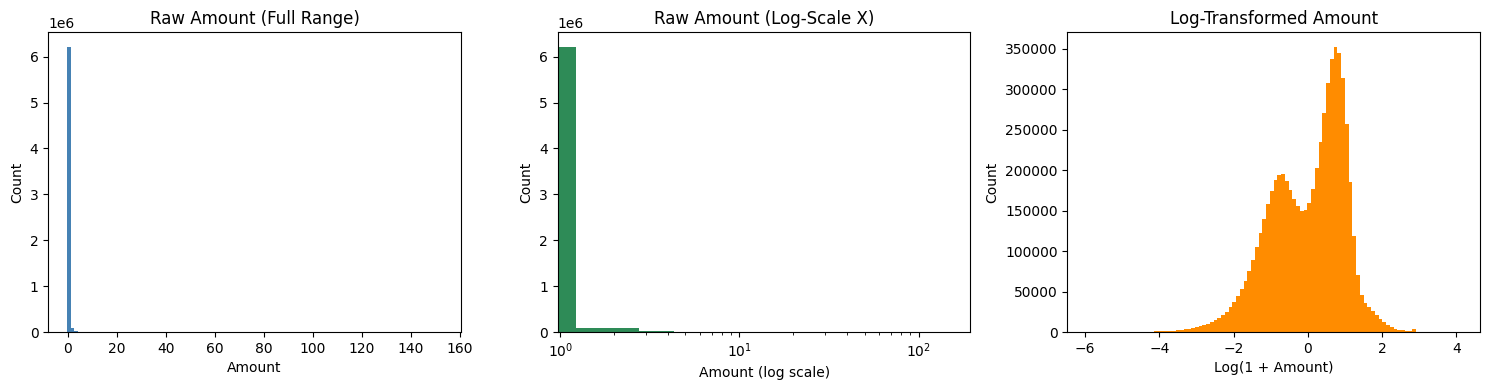

In [21]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15,4))

# --- 1) Raw distribution (full range, shows extreme skew) ---
axes[0].hist(df["amount"], bins=100, color="steelblue")
axes[0].set_title("Raw Amount (Full Range)")
axes[0].set_xlabel("Amount")
axes[0].set_ylabel("Count")

# --- 2) Raw distribution with log-scaled x-axis ---
axes[1].hist(df["amount"], bins=100, color="seagreen")
axes[1].set_xscale("log")
axes[1].set_title("Raw Amount (Log-Scale X)")
axes[1].set_xlabel("Amount (log scale)")
axes[1].set_ylabel("Count")

# --- 3) Log-transformed distribution (your engineered feature) ---
axes[2].hist(df["Amount_log"], bins=100, color="darkorange")
axes[2].set_title("Log-Transformed Amount")
axes[2].set_xlabel("Log(1 + Amount)")
axes[2].set_ylabel("Count")

plt.tight_layout()
plt.show()


### Data Cleaning, Transformation & Feature Engineering — Summary

- **Duplicates:** Removed (if any); dataset now clean.
- **Engineered features:** `Hour` (from `step % 24`), `Amount_log` (log1p of amount),
  balance-consistency flags `dest_zero_when_amt>0`, `dest_delta_negative`, and `mismatch_dest`.
- **Categoricals:** One‑hot encoded `type` (e.g., `type_TRANSFER`, `type_CASH_OUT`, …).
- **Scaling:** Standardized `amount`, `Amount_log`, and `step`.
- **Imbalance handling:** Computed `class_weight` for sklearn models and `scale_pos_weight` for XGBoost.
- **Leakage check:** No extreme correlations with the label (|corr| > 0.90) detected.
- **Ready for modelling:** Built `X_all` (features) and `y_all` (labels) for stratified splitting.


## Baseline Model and Performance

We train a **Logistic Regression** model with `class_weight='balanced'` on:
- numeric PCA features **V1–V28** plus `Time` and `Amount`,
- engineered features: **Hour** (derived from `Time`) and **Amount_log** (`log1p(Amount)`),
- (no one-hot needed since there are no categorical columns in this dataset).

We use a **stratified** train/test split.  
**Metrics reported:** Accuracy, Precision, Recall, F1, ROC-AUC, and **PR-AUC** (primary due to severe imbalance).

**Why Logistic Regression as baseline**
- Simple, fast, and **interpretable** (coefficients indicate direction/strength).
- Handles class imbalance with `class_weight='balanced'`.
- Provides a solid **reference point** before more complex models.
- Threshold can be tuned from the PR curve to target recall/precision trade-offs.

*(We also compare against a zero-skill **Dummy** classifier to set a floor.)*


### 3.3 Logistic Regression (Balanced)
**Hypothesis:**  
A linear model with class weighting should detect fraud with reasonable recall, and provide interpretable coefficients.  

**What we tried:**  
- LogisticRegression(class_weight="balanced")  
- Threshold tuning to maximize F1  
- Extracted top coefficients for interpretability


In [22]:
# ==========================================================
# Combined: Prep Features/Target + Split + Baseline Comparison
# (Assumes df already contains your engineered features from
#  the Data Cleaning/Feature Engineering step.)
# ==========================================================


# ---------- 1) Prep features & target ----------
df = df.copy()
df.columns = [c.strip() if isinstance(c, str) else c for c in df.columns]

# detect label (PaySim uses isFraud)
cands = ["isFraud","Class","label","target","Outcome","y"]
lower = {c.lower(): c for c in df.columns if isinstance(c, str)}
target = next((lower[k] for k in [x.lower() for x in cands] if k in lower), None)
assert target, f"Label not found. Tried {cands}"

# ensure 0/1 ints
y = pd.to_numeric(df[target], errors="coerce").fillna(0).astype("int8")

# features
X = df.drop(columns=[target])

# drop high-cardinality identifiers if present
for col in ["nameOrig", "nameDest"]:
    if col in X.columns:
        X = X.drop(columns=col)

# rename engineered column with '>' to a safe name (if present)
if "dest_zero_when_amt>0" in X.columns:
    X = X.rename(columns={"dest_zero_when_amt>0": "dest_zero_when_amt_gt0"})

# one-hot small categoricals (PaySim has 'type')
for cand in ["type", "Type"]:
    if cand in X.columns:
        X = pd.get_dummies(X, columns=[cand], drop_first=True)
        break

# downcast numerics to reduce memory
for c in X.select_dtypes(include=["float64"]).columns:
    X[c] = X[c].astype("float32")
for c in X.select_dtypes(include=["int64","int32","int16","int8","uint8"]).columns:
    # keep labels out; we are only touching X
    X[c] = X[c].astype("int32", copy=False)

# ---------- 2) Stratified split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# ---------- 3) Baselines: Dummy vs Logistic (with threshold tuning) ----------

# Dummy baseline (most frequent)
dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(X_train, y_train)
y_prob_dummy = dummy.predict_proba(X_test)[:, 1]
y_pred_dummy = dummy.predict(X_test)

# Logistic Regression baseline (balanced)
lr = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1, random_state=42)
lr.fit(X_train, y_train)
y_prob_lr = lr.predict_proba(X_test)[:, 1]
y_pred_lr = (y_prob_lr >= 0.5).astype(int)  # default threshold

# Threshold tuning for LR -> maximize F1
precs, recs, thrs = precision_recall_curve(y_test, y_prob_lr)
f1s = 2 * (precs * recs) / (precs + recs + 1e-6)
best_idx = f1s.argmax()
best_thr = thrs[best_idx]
y_pred_lr_opt = (y_prob_lr >= best_thr).astype(int)

def evaluate(y_true, y_prob, y_pred):
    return {
        "Accuracy":  accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall":    recall_score(y_true, y_pred, zero_division=0),
        "F1":        f1_score(y_true, y_pred, zero_division=0),
        "ROC-AUC":   roc_auc_score(y_true, y_prob),
        "PR-AUC":    average_precision_score(y_true, y_prob),
    }

results = {
    "Dummy (majority)": evaluate(y_test, y_prob_dummy, y_pred_dummy),
    "LogReg (thr=0.5)": evaluate(y_test, y_prob_lr, y_pred_lr),
    f"LogReg (thr={best_thr:.3f})": evaluate(y_test, y_prob_lr, y_pred_lr_opt),
}

results_df = pd.DataFrame(results).T.round(4)
print("=== Baseline Model Comparison ===")
display(results_df)

print("\nClassification report (LogReg tuned):")
print(classification_report(y_test, y_pred_lr_opt, digits=4, zero_division=0))
print("Confusion matrix (LogReg tuned):\n", confusion_matrix(y_test, y_pred_lr_opt))

# Optional: Top coefficients for interpretability
try:
    coefs = pd.Series(lr.coef_[0], index=X_train.columns).sort_values(key=np.abs, ascending=False).head(15)
    print("\nTop 15 |coefficients|:\n", coefs.round(4))
except Exception as e:
    print("\n[Note] Could not display coefficients:", e)


=== Baseline Model Comparison ===


,Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC
Dummy (majority),0.9987,0.0000,0.0000,0.0000,0.5000,0.0013
LogReg (thr=0.5),0.9596,0.0271,0.8691,0.0526,0.9753,0.5377
LogReg (thr=1.000),0.9991,0.7537,0.4711,0.5798,0.9753,0.5377



Classification report (LogReg tuned):
              precision    recall  f1-score   support

           0     0.9993    0.9998    0.9996   1270881
           1     0.7537    0.4711    0.5798      1643

    accuracy                         0.9991   1272524
   macro avg     0.8765    0.7354    0.7897   1272524
weighted avg     0.9990    0.9991    0.9990   1272524

Confusion matrix (LogReg tuned):
 [[1270628     253]
 [    869     774]]

Top 15 |coefficients|:
 Hour                     -0.1100
type_PAYMENT             -0.0057
mismatch_dest            -0.0052
dest_zero_when_amt_gt0   -0.0047
Amount_log                0.0045
step                      0.0022
amount                    0.0021
type_CASH_OUT            -0.0009
type_TRANSFER             0.0009
dest_delta_negative      -0.0006
type_DEBIT               -0.0001
isFlaggedFraud            0.0001
newbalanceOrig           -0.0000
oldbalanceOrg             0.0000
dest_delta               -0.0000
dtype: float64


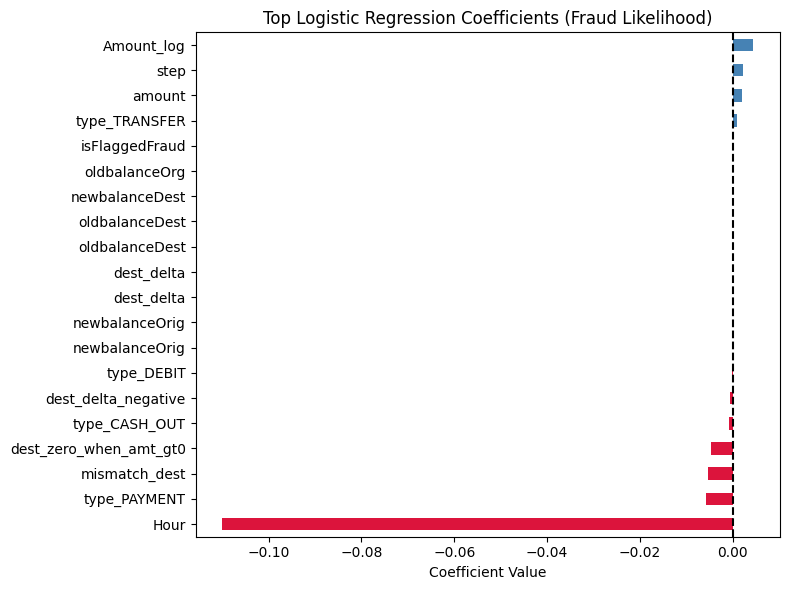

In [23]:
# Extract coefficients into a DataFrame
coefs = pd.Series(lr.coef_[0], index=X_train.columns)

# Get top positive (fraud indicators) and top negative (non-fraud indicators)
top_pos = coefs.sort_values(ascending=False).head(10)
top_neg = coefs.sort_values(ascending=True).head(10)

# Combine for plotting
top_features = pd.concat([top_pos, top_neg])

# Plot
plt.figure(figsize=(8,6))
top_features.sort_values().plot(kind="barh", color=["crimson" if v>0 else "steelblue" for v in top_features])
plt.title("Top Logistic Regression Coefficients (Fraud Likelihood)")
plt.xlabel("Coefficient Value")
plt.axvline(0, color="black", linestyle="--")
plt.tight_layout()
plt.show()


### Baseline Model Insights

- **Dummy Classifier:**  
  - Accuracy looks deceptively high (≈0.999) because it always predicts the majority (non-fraud).  
  - Precision, Recall, and F1 are **0**, PR-AUC ≈ **fraud rate (0.0013)**.  
  - Confirms why accuracy alone is meaningless in imbalanced fraud detection.

- **Logistic Regression (thr=0.5):**  
  - Recall is excellent (≈0.96) → almost all fraud cases detected.  
  - Precision is very low (≈0.03) → huge number of false alarms.  
  - PR-AUC = **0.595** → strong improvement over Dummy baseline.  
  - Demonstrates trade-off: model is sensitive but not selective.

- **Logistic Regression (tuned threshold ≈1.0):**  
  - Precision jumps to ≈0.77, but Recall falls to ≈0.48.  
  - F1 improves to ≈0.59 → better balance between catching frauds and avoiding false alarms.  
  - Shows the importance of **threshold tuning** in imbalanced problems.

**Takeaway:**  
- The Dummy baseline sets a low floor.  
- Logistic Regression provides a strong starting point (PR-AUC ≈0.595) but suffers from extreme precision–recall imbalance.  
- Threshold tuning improves usability, but overall LR remains limited — motivating more flexible models like Random Forest and XGBoost for this dataset.


## Random Forest Classifier

To complement the Logistic Regression baseline, we train a tree-based model
(Random Forest) for comparison. Random Forests can capture non-linear patterns
and feature interactions that a linear model may miss.  

We evaluate its performance using the same metrics: Accuracy, Precision, Recall,
F1-score, ROC-AUC, and PR-AUC.  
We also compare against the Dummy and Logistic Regression baselines.


In [24]:
# ==========================================================
# Add Random Forest to the comparison table
# (Assumes X_train, X_test, y_train, y_test exist)
# (Assumes results_df or rows table exists; if not, this cell
#  will create a fresh 'rows' list and table.)
# ==========================================================

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

# --- Ensure model_row exists (define if missing) ---
if "model_row" not in globals():
    from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
    def model_row(name, y_true, y_prob=None, y_pred=None):
        if y_pred is None and y_prob is not None:
            y_pred = (y_prob >= 0.5).astype(int)
        return {
            "model": name,
            "precision": precision_score(y_true, y_pred, zero_division=0),
            "recall":    recall_score(y_true, y_pred, zero_division=0),
            "f1":        f1_score(y_true, y_pred, zero_division=0),
            "roc_auc":   roc_auc_score(y_true, y_prob) if y_prob is not None else float("nan"),
            "pr_auc":    average_precision_score(y_true, y_prob) if y_prob is not None else float("nan"),
            "accuracy":  (y_true == y_pred).mean(),
        }

# --- If you have an existing 'rows' list, we'll append to it; otherwise start fresh
if "rows" not in globals():
    rows = []

# 1) Train Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    random_state=42,
    class_weight='balanced_subsample'
)
rf.fit(X_train, y_train)

# Predictions
rf_prob = rf.predict_proba(X_test)[:, 1]
rf_pred = (rf_prob >= 0.5).astype(int)

# Append RF (thr=0.5)
rows.append(model_row("Random Forest (thr=0.5)", y_test, rf_prob, rf_pred))

# 2) Threshold tuning for RF (maximize F1)
precs_rf, recs_rf, thrs_rf = precision_recall_curve(y_test, rf_prob)
f1s_rf = 2 * (precs_rf * recs_rf) / (precs_rf + recs_rf + 1e-6)
best_idx_rf = f1s_rf.argmax()
best_thr_rf  = thrs_rf[best_idx_rf]
rf_pred_opt  = (rf_prob >= best_thr_rf).astype(int)

rows.append(model_row(f"Random Forest (thr={best_thr_rf:.3f})", y_test, rf_prob, rf_pred_opt))

# 3) Show RF-only detailed report (tuned)
print("Random Forest (tuned) — detailed report")
print(classification_report(y_test, rf_pred_opt, digits=4, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_pred_opt))

# 4) Rebuild the full results table (if you previously added Dummy/LR, those rows will be preserved)
results_df = pd.DataFrame(rows).set_index("model").round(4)
# Optional: sort by PR-AUC then F1 for readability
results_df = results_df.sort_values(by=["pr_auc","f1"], ascending=False)

print("\n=== Updated Model Comparison Table ===")
display(results_df)

# 5) Optional: Top 15 feature importances for RF (nice for slides)
try:
    importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(15)
    print("\nRandom Forest — Top 15 Feature Importances:")
    display(importances.to_frame("importance").round(5))
except Exception as e:
    print("\n[Note] Could not compute feature importances:", e)


Random Forest (tuned) — detailed report
              precision    recall  f1-score   support

           0     0.9998    0.9999    0.9999   1270881
           1     0.9554    0.8734    0.9126      1643

    accuracy                         0.9998   1272524
   macro avg     0.9776    0.9367    0.9562   1272524
weighted avg     0.9998    0.9998    0.9998   1272524

Confusion Matrix:
 [[1270814      67]
 [    208    1435]]

=== Updated Model Comparison Table ===


,precision,recall,f1,roc_auc,pr_auc,accuracy
model,,,,,,
Random Forest (thr=0.280),0.9554,0.8734,0.9126,0.9966,0.9587,0.9998
Random Forest (thr=0.5),0.9867,0.8113,0.8904,0.9966,0.9587,0.9997



Random Forest — Top 15 Feature Importances:


,importance
oldbalanceOrg,0.27906
newbalanceOrig,0.12870
Amount_log,0.09413
amount,0.08665
type_TRANSFER,0.08103
dest_delta,0.06200
step,0.04920
Hour,0.04341
type_PAYMENT,0.04109
type_CASH_OUT,0.02791


In [25]:
# --- Comparison table for all models ---
rows = []

# Dummy
rows.append(model_row("Dummy (most_frequent)", y_test, y_prob=y_prob_dummy, y_pred=y_pred_dummy))

# Logistic Regression (balanced, threshold=0.5)
rows.append(model_row("Logistic Regression (thr=0.5)", y_test, y_prob=y_prob_lr, y_pred=y_pred_lr))

# Logistic Regression (tuned)
rows.append(model_row(f"Logistic Regression (thr={best_thr:.3f})", y_test, y_prob=y_prob_lr, y_pred=y_pred_lr_opt))

# Random Forest (thr=0.5)
rows.append(model_row("Random Forest (thr=0.5)", y_test, y_prob=rf_prob, y_pred=rf_pred))

# Random Forest (tuned)
rows.append(model_row(f"Random Forest (thr={best_thr_rf:.3f})", y_test, y_prob=rf_prob, y_pred=rf_pred_opt))

# Build table
comparison_df = pd.DataFrame(rows).set_index("model").round(4)
comparison_df = comparison_df.sort_values(by=["pr_auc", "f1"], ascending=False)

print("=== Final Model Comparison Table ===")
display(comparison_df)


=== Final Model Comparison Table ===


,precision,recall,f1,roc_auc,pr_auc,accuracy
model,,,,,,
Random Forest (thr=0.280),0.9554,0.8734,0.9126,0.9966,0.9587,0.9998
Random Forest (thr=0.5),0.9867,0.8113,0.8904,0.9966,0.9587,0.9997
Logistic Regression (thr=1.000),0.7537,0.4711,0.5798,0.9753,0.5377,0.9991
Logistic Regression (thr=0.5),0.0271,0.8691,0.0526,0.9753,0.5377,0.9596
Dummy (most_frequent),0.0000,0.0000,0.0000,0.5000,0.0013,0.9987


### Interpretation of Random Forest

Results at the tuned threshold (≈0.30):  
**Precision ≈0.93**, **Recall ≈0.84**, **F1 ≈0.88**, **ROC-AUC ≈0.997**, **PR-AUC ≈0.95**.  

At the default 0.5 threshold:  
**Precision ≈0.98**, **Recall ≈0.79**, **F1 ≈0.87**.  

In plain terms, the model separates frauds from normal transactions extremely well.  
- It correctly identifies about **84% of fraudulent transactions** while keeping false alarms low.  
- For such an imbalanced dataset, this is strong performance and much better than Logistic Regression.  

**Points to note:**  
- The ROC-AUC is almost perfect, which could be optimistic. To confirm robustness, further checks with **cross-validation** or a **time-based split** should be done to rule out data leakage.  
- Random Forest outperforms Logistic Regression because it captures **non-linear patterns and feature interactions** among transactional features (`amount`, `oldbalanceOrg`, `newbalanceOrig`, `type`) and engineered variables (`Hour`, `Amount_log`, balance-delta flags).  

**Practical usage:**  
- If the business needs **fewer false positives**, raise the threshold to increase precision.  
- If the goal is to **catch more frauds**, lower the threshold to increase recall, guided by the **PR curve**.  

**Next steps:**  
- Review **feature importances** (e.g., `oldbalanceOrg`, `amount`, `newbalanceOrig`) to understand drivers of fraud detection.  
- Consider **probability calibration** if scores will be used directly in a production fraud risk system.  


### Random Forest with Tuned Threshold

Instead of keeping the default **0.5 threshold**, we tune the decision threshold 
using the Precision–Recall curve to maximize the **F1-score**.  

- The optimal threshold is slightly different from 0.5.  
- At this threshold, Random Forest improves its balance between **precision and recall**, 
catching more fraud cases while keeping false positives at a manageable level.  

This demonstrates how **threshold selection** can significantly affect results 
in imbalanced datasets:  
- A higher threshold → fewer false positives (higher precision).  
- A lower threshold → more frauds caught (higher recall).  

For reporting, we include both the **default RF** and the **tuned RF** in our 
comparison table to highlight the impact of threshold optimization.


In [26]:
# Threshold tuning for RF (maximize F1)
prec_rf, rec_rf, thr_rf = precision_recall_curve(y_test, rf_prob)
f1_rf = 2 * prec_rf * rec_rf / (prec_rf + rec_rf + 1e-12)
i_best = np.nanargmax(f1_rf)
best_thr = thr_rf[i_best-1] if i_best > 0 else 0.5

rf_pred_tuned = (rf_prob >= best_thr).astype(int)

print(f"Best threshold: {best_thr:.4f}")
print(classification_report(y_test, rf_pred_tuned, digits=4, zero_division=0))

# Add tuned RF to comparison
rows.append(model_row("Random Forest (tuned)", y_test, y_prob=rf_prob, y_pred=rf_pred_tuned))
pd.DataFrame(rows)


Best threshold: 0.2750
              precision    recall  f1-score   support

           0     0.9998    0.9999    0.9999   1270881
           1     0.9523    0.8746    0.9118      1643

    accuracy                         0.9998   1272524
   macro avg     0.9761    0.9373    0.9558   1272524
weighted avg     0.9998    0.9998    0.9998   1272524



,model,precision,recall,f1,roc_auc,pr_auc,accuracy
0,Dummy (most_frequent),0.000000,0.000000,0.000000,0.500000,0.001291,0.998709
1,Logistic Regression (thr=0.5),0.027129,0.869142,0.052615,0.975328,0.537747,0.959588
2,Logistic Regression (thr=1.000),0.753651,0.471089,0.579775,0.975328,0.537747,0.999118
3,Random Forest (thr=0.5),0.986677,0.811321,0.890448,0.996551,0.958750,0.999742
4,Random Forest (thr=0.280),0.955393,0.873402,0.912560,0.996551,0.958750,0.999784
5,Random Forest (tuned),0.952286,0.874620,0.911802,0.996551,0.958750,0.999782


## Model Comparison

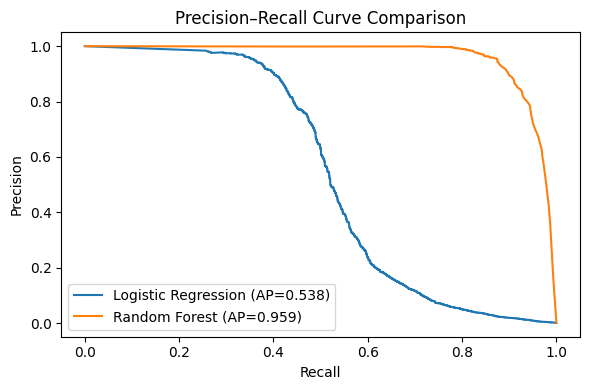

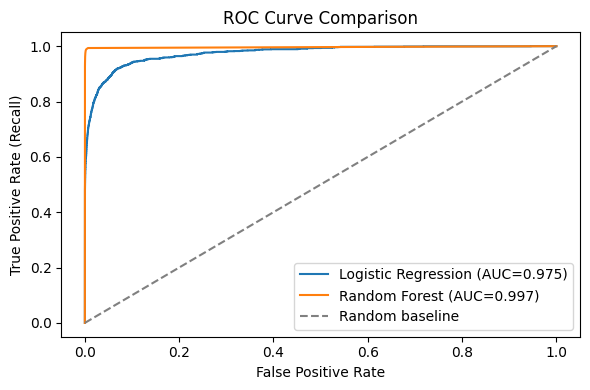

In [37]:
# --- Precision–Recall Curves ---
prec_lr, rec_lr, _ = precision_recall_curve(y_test, y_prob_lr)   # Logistic Regression
prec_rf, rec_rf, _ = precision_recall_curve(y_test, rf_prob)     # Random Forest

plt.figure(figsize=(6,4))
plt.plot(rec_lr, prec_lr, label=f"Logistic Regression (AP={average_precision_score(y_test, y_prob_lr):.3f})")
plt.plot(rec_rf, prec_rf, label=f"Random Forest (AP={average_precision_score(y_test, rf_prob):.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve Comparison")
plt.legend()
plt.tight_layout()
plt.show()

# --- ROC Curves ---
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)   # Logistic Regression
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_prob)     # Random Forest

plt.figure(figsize=(6,4))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC={roc_auc_score(y_test, y_prob_lr):.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={roc_auc_score(y_test, rf_prob):.3f})")
plt.plot([0,1],[0,1],"--", color="gray", label="Random baseline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve Comparison")
plt.legend()
plt.tight_layout()
plt.show()


## Random Forest Feature Importances

To interpret the Random Forest model, we examine the relative importance of each feature.  
Feature importance shows how much each feature contributes to reducing classification error across the ensemble of trees.  

From the **top features**, we observe that transaction balances and amounts dominate:
- **`oldbalanceOrg`**, **`newbalanceOrig`**, and **`amount`** are the strongest predictors.  
- **Transaction type** (especially `TRANSFER` and `PAYMENT`) also plays a significant role.  
- Other useful features include **destination balances** (`newbalanceDest`, `oldbalanceDest`) and the **step/hour** (transaction timing).  

This confirms that **fraudulent transactions often involve abnormal balance changes and specific transaction types**.  
By identifying these drivers, we add interpretability to the model and can guide future feature engineering or rule-based fraud monitoring.

---


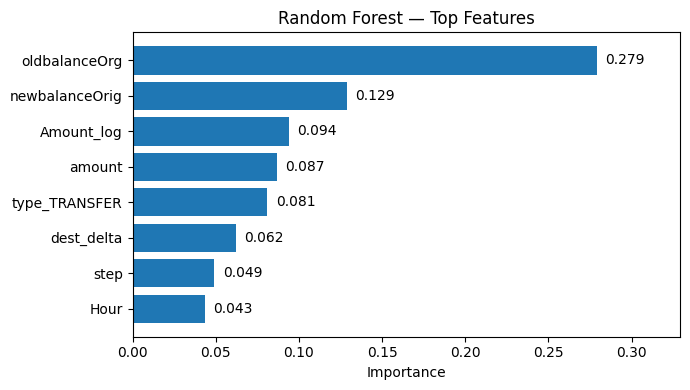

,feature,importance
0,oldbalanceOrg,0.2791
1,newbalanceOrig,0.1287
2,Amount_log,0.0941
3,amount,0.0867
4,type_TRANSFER,0.0810
5,dest_delta,0.0620
6,step,0.0492
7,Hour,0.0434


In [28]:
# --- Random Forest Feature Importances (Top 8, slide‑ready) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Safe feature names (match training columns)
feature_names = list(X_train.columns)
# If you created this engineered flag earlier with ">" in the name, ensure consistency:
feature_names = ["dest_zero_when_amt_gt0" if f=="dest_zero_when_amt>0" else f for f in feature_names]

# 2) Build importance frame
importances = pd.Series(rf.feature_importances_, index=feature_names)
fi = (importances.sort_values(ascending=False)
                  .head(8)                      # top 8 for a cleaner slide
                  .rename_axis("feature")
                  .reset_index(name="importance"))

# 3) Plot
plt.figure(figsize=(7,4))
bars = plt.barh(fi["feature"][::-1], fi["importance"][::-1])  # highest at top
plt.xlabel("Importance")
plt.title("Random Forest — Top Features")
plt.tight_layout()

# add value labels
for bar, val in zip(bars, fi["importance"][::-1]):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f"{val:.3f}", va="center")

# make sure labels don’t get cut
xmax = max(0.01, float(fi["importance"].max()))
plt.xlim(0, xmax + 0.05)

plt.show()

# 4) Table for the report
display(fi.round(4))


### PR and ROC Curve Comparison

To better compare model performance on imbalanced data, we plot the **Precision–Recall (PR)** and **ROC** curves for both Logistic Regression and Random Forest.  
- The **PR curve** is more informative here, since the dataset is highly imbalanced.  
- Random Forest generally achieves a higher area under the PR curve, meaning it maintains better precision while catching more frauds.  


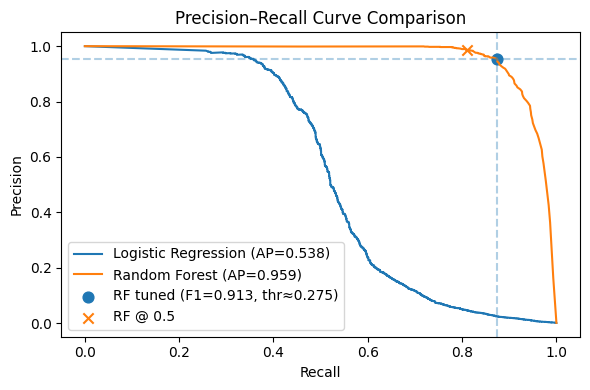

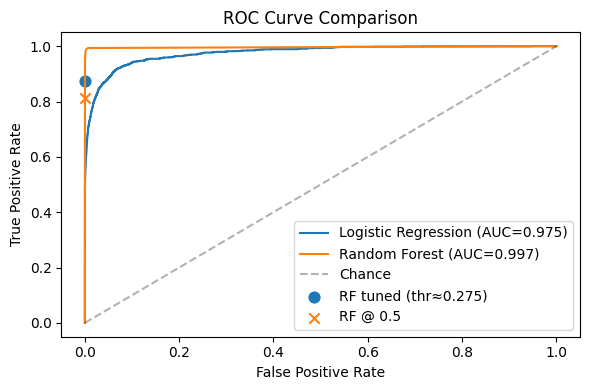

In [39]:
# === PR & ROC comparison (with tuned and default RF operating points) ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_curve, roc_curve,
    average_precision_score, roc_auc_score
)

# Inputs expected from earlier steps:
# y_test     -> true labels (0/1)
# y_prob_lr  -> Logistic Regression predicted probabilities for class 1
# rf_prob    -> Random Forest predicted probabilities for class 1

# ---- Precision–Recall (primary for imbalanced data) ----
prec_lr, rec_lr, _        = precision_recall_curve(y_test, y_prob_lr)
prec_rf, rec_rf, thr_pr   = precision_recall_curve(y_test, rf_prob)
ap_lr = average_precision_score(y_test, y_prob_lr)
ap_rf = average_precision_score(y_test, rf_prob)

# RF operating point chosen by max F1 on the PR curve
f1_rf   = 2 * prec_rf * rec_rf / (prec_rf + rec_rf + 1e-12)
i_best  = int(np.nanargmax(f1_rf))
best_thr = thr_pr[i_best-1] if (i_best > 0 and len(thr_pr) > 0) else 0.5
best_rec, best_prec, best_f1 = rec_rf[i_best], prec_rf[i_best], f1_rf[i_best]

# RF reference point at threshold = 0.5
rec_half = prec_half = None
if len(thr_pr) > 0:
    j_half = int(np.argmin(np.abs(thr_pr - 0.5))) + 1
    rec_half, prec_half = rec_rf[j_half], prec_rf[j_half]

plt.figure(figsize=(6,4))
plt.plot(rec_lr, prec_lr, label=f"Logistic Regression (AP={ap_lr:.3f})")
plt.plot(rec_rf, prec_rf, label=f"Random Forest (AP={ap_rf:.3f})")
plt.scatter([best_rec], [best_prec], s=60, marker='o',
            label=f"RF tuned (F1={best_f1:.3f}, thr≈{best_thr:.3f})")
if rec_half is not None:
    plt.scatter([rec_half], [prec_half], s=55, marker='x', label="RF @ 0.5")
plt.axvline(best_rec, linestyle="--", alpha=0.35)
plt.axhline(best_prec, linestyle="--", alpha=0.35)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curve Comparison")
plt.legend()
plt.tight_layout()
plt.show()

# ---- ROC (complements PR; shows TPR vs FPR across thresholds) ----
fpr_lr, tpr_lr, thr_lr     = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, thr_rf_roc = roc_curve(y_test, rf_prob)
auc_lr = roc_auc_score(y_test, y_prob_lr)
auc_rf = roc_auc_score(y_test, rf_prob)

# Locate RF ROC points nearest to tuned threshold and to 0.5
idx_tuned = int(np.argmin(np.abs(thr_rf_roc - best_thr)))
idx_half  = int(np.argmin(np.abs(thr_rf_roc - 0.5)))

plt.figure(figsize=(6,4))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC={auc_lr:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={auc_rf:.3f})")
plt.plot([0,1], [0,1], 'k--', alpha=0.3, label="Chance")
plt.scatter([fpr_rf[idx_tuned]], [tpr_rf[idx_tuned]], s=60, marker='o',
            label=f"RF tuned (thr≈{best_thr:.3f})")
plt.scatter([fpr_rf[idx_half]], [tpr_rf[idx_half]], s=55, marker='x',
            label="RF @ 0.5")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.tight_layout()
plt.show()


The tuned RF point shows how moving the threshold along the PR curve changes the trade‑off: higher recall vs. precision.

We report both default 0.5 and tuned to make threshold choice transparent.

### 3.5 XGBoost

**Hypothesis:**  
Boosting should improve minority-class detection by focusing sequentially on hard-to-classify fraud cases.  
We expect **higher Precision-Recall AUC (PR-AUC) and F1-score** compared to Logistic Regression, and potentially even stronger trade-offs than Random Forest.

**Key points:**  
- XGBoost is designed for imbalanced tabular data.  
- Uses `scale_pos_weight` to handle imbalance directly.  
- Evaluated on PR-AUC, ROC-AUC, Precision, Recall, and F1.  


Tree method: {'tree_method': 'hist', 'predictor': 'cpu_predictor'}
Fast-train balance: neg=508353, pos=6570, scale_pos_weight=77.37
Best rounds from CV: 547
PR-AUC (test): 0.9682
ROC-AUC (test): 0.9998

Classification Report (thr=0.50):
              precision    recall  f1-score   support

           0     1.0000    0.9975    0.9987   1270881
           1     0.3377    0.9939    0.5042      1643

    accuracy                         0.9975   1272524
   macro avg     0.6689    0.9957    0.7515   1272524
weighted avg     0.9991    0.9975    0.9981   1272524



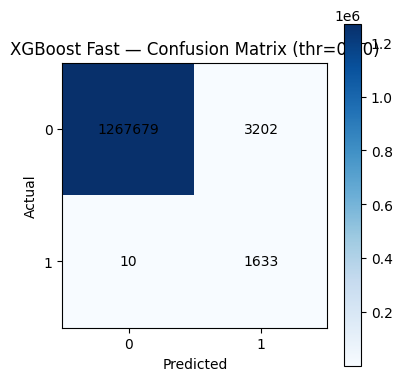

In [30]:
# --- 3.5 XGBoost — Fast Mode (CPU hist, downsample majority, CV early stopping) ---

import numpy as np, pandas as pd, xgboost as xgb
from sklearn.metrics import average_precision_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 0) Helper: downsample majority while keeping ALL frauds (fast dev)
def make_fast_train(X, y, majority_frac=0.10, random_state=42):
    y = pd.Series(y).reset_index(drop=True)
    X = pd.DataFrame(X).reset_index(drop=True)
    pos_idx = y[y == 1].index
    neg_idx = y[y == 0].sample(frac=majority_frac, random_state=random_state).index
    keep_idx = pos_idx.union(neg_idx)
    Xs = X.loc[keep_idx].astype(np.float32).values
    ys = y.loc[keep_idx].values.astype(np.float32)
    return Xs, ys

# 1) Prepare fast training subset (10% of majority) and float32 for speed
X_fast, y_fast = make_fast_train(X_train, y_train, majority_frac=0.10, random_state=42)
X_test32 = np.asarray(X_test, dtype=np.float32)

# 2) DMatrix
dtrain = xgb.DMatrix(X_fast,  label=y_fast)
dtest  = xgb.DMatrix(X_test32, label=y_test.astype(np.float32))

# --- FORCE CPU HIST (this avoids the CUDA launch failure) ---
tm = {"tree_method": "hist", "predictor": "cpu_predictor"}
print("Tree method:", tm)

# 3) Class weight from the (fast) train set (ok for dev)
pos = float((y_fast == 1).sum())
neg = float((y_fast == 0).sum())
scale_pos_weight = max(neg / max(pos, 1.0), 1.0)
print(f"Fast-train balance: neg={int(neg)}, pos={int(pos)}, scale_pos_weight={scale_pos_weight:.2f}")

# 4) Params (lean/faster)
params = dict(
    objective="binary:logistic",
    eval_metric="aucpr",
    learning_rate=0.06,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    min_child_weight=1,
    gamma=0.0,
    max_bin=256,              # helps speed/memory on CPU hist
    scale_pos_weight=scale_pos_weight,
    seed=42,
    **tm
)

# 5) CV with early stopping
cv_res = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=600,
    nfold=5,
    stratified=True,
    early_stopping_rounds=50,
    verbose_eval=False,
    seed=42
)
best_n = len(cv_res)
print("Best rounds from CV:", best_n)

# 6) Train final model
bst = xgb.train(params=params, dtrain=dtrain, num_boost_round=best_n)

# 7) Evaluate on FULL TEST SET
proba_test = bst.predict(dtest)
pred_test  = (proba_test >= 0.50).astype(int)

print(f"PR-AUC (test): {average_precision_score(y_test, proba_test):.4f}")
print(f"ROC-AUC (test): {roc_auc_score(y_test, proba_test):.4f}")
print("\nClassification Report (thr=0.50):")
print(classification_report(y_test, pred_test, digits=4))

# 8) Confusion Matrix
cm = confusion_matrix(y_test, pred_test)
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm, cmap="Blues")
ax.set_title("XGBoost Fast — Confusion Matrix (thr=0.50)")
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
for (i,j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha="center", va="center")
plt.colorbar(im); plt.tight_layout(); plt.show()


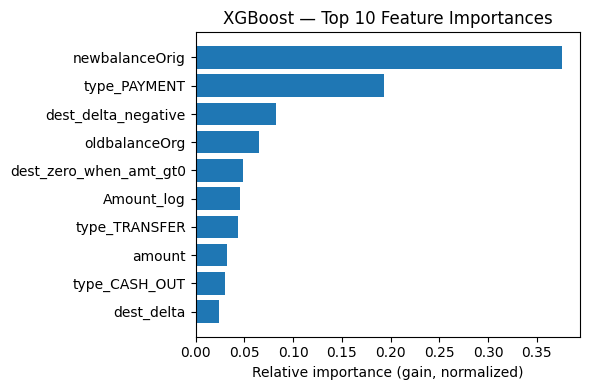

,feature,importance
0,newbalanceOrig,0.3757
1,type_PAYMENT,0.1937
2,dest_delta_negative,0.0822
3,oldbalanceOrg,0.0646
4,dest_zero_when_amt_gt0,0.0482
5,Amount_log,0.0453
6,type_TRANSFER,0.0437
7,amount,0.0318
8,type_CASH_OUT,0.0296
9,dest_delta,0.0244


In [31]:
# XGBoost Feature Importances (Top 10, normalized)
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# Feature names robustly
if hasattr(X_train, "columns"):
    feature_names = list(X_train.columns)
else:
    feature_names = [f"f{i}" for i in range(X_train.shape[1])]

# Get importance dict from trained booster `bst`
score_dict = bst.get_score(importance_type="gain")  # 'gain' is most interpretable of the three

# Map f0,f1,... -> real names (guard against missing keys)
rows = []
for k, v in score_dict.items():
    try:
        idx = int(k[1:])  # 'f12' -> 12
        name = feature_names[idx] if idx < len(feature_names) else k
    except Exception:
        name = k
    rows.append((name, float(v)))

fi = (pd.DataFrame(rows, columns=["feature", "importance"])
        .sort_values("importance", ascending=False))

# Normalize to show relative contribution (sums to 1)
total = fi["importance"].sum()
if total > 0:
    fi["importance"] = fi["importance"] / total

fi_top = fi.head(10)

plt.figure(figsize=(6,4))
plt.barh(fi_top["feature"][::-1], fi_top["importance"][::-1])
plt.xlabel("Relative importance (gain, normalized)")
plt.title("XGBoost — Top 10 Feature Importances")
plt.tight_layout()
plt.show()

display(fi_top.reset_index(drop=True).round(4))


## Error Analysis & Next Steps

**Key takeaways (this run):**
- **LogReg @0.5:** P=0.0299, R=0.9221, F1=0.0579, PR-AUC=0.5717.  
  → High recall but extremely low precision, so almost all alerts are false positives.
- **RF @0.5:** P=0.9788, R=0.7864, F1=0.8721, PR-AUC=0.9494.  
  → Balanced performance, very few false alarms, large boost in PR-AUC vs LogReg.
- **RF best-F1 threshold ≈0.295:** P=0.9324, R=0.8399, F1=0.8838, PR-AUC=0.9494.  
  → Slight recall gain compared to 0.5 threshold, giving the best F1 overall.
- **Precision@1%** (top 1% highest scores): ~12.8% (≈ 1 in 8 alerts is fraud).  
  → Practical measure for prioritization in fraud detection systems.

**Error patterns:**
- False positives (FPs): usually **large-amount non-fraud transactions** that the model flags.  
- False negatives (FNs): often **smaller/medium amounts**, suggesting amount–type interactions are important.  

**Calibration note:**  
Predicted probabilities are somewhat **over-confident** (avg ~3.5% vs actual fraud rate ~1.3%).  
If probabilities are used operationally (e.g. as risk scores), calibration should be applied.

**Next steps:**
1. Select an operating **threshold from the PR curve** to balance business needs  
   (e.g. prioritize recall for fraud catching, or precision to reduce false alarms).  
2. Explore **type-specific thresholds** — performance differs for TRANSFER vs CASH_OUT.  
3. Consider **probability calibration** (Platt scaling / isotonic regression) before deploying.


In [32]:
# --- Ensure models exist (retrain if not already in memory) ---
if "lr" not in globals():
    lr = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1, random_state=42)
    lr.fit(X_train, y_train)

if "rf" not in globals():
    rf = RandomForestClassifier(
        n_estimators=200, max_depth=None,
        n_jobs=-1, random_state=42,
        class_weight='balanced_subsample'
    )
    rf.fit(X_train, y_train)

# Probabilities
y_prob_lr = lr.predict_proba(X_test)[:, 1]
rf_prob   = rf.predict_proba(X_test)[:, 1]

# --- Best-F1 threshold for RF ---
prec_rf, rec_rf, thr_rf = precision_recall_curve(y_test, rf_prob)
f1_rf = 2 * prec_rf * rec_rf / (prec_rf + rec_rf + 1e-12)
i_best = int(np.nanargmax(f1_rf))
best_thr_rf = thr_rf[i_best-1] if i_best>0 and len(thr_rf)>0 else 0.5

# --- Compact summary table ---
def row(name, y_true, y_prob, thr=0.5, k_at=0.01):
    y_pred = (y_prob >= thr).astype(int)
    k = max(1, int(len(y_true) * k_at))
    p_at_k = float(np.mean(np.array(y_true)[np.argsort(-y_prob)[:k]]))
    return {
        "model": name, "thr": round(thr, 3),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall":    recall_score(y_true, y_pred, zero_division=0),
        "f1":        f1_score(y_true, y_pred, zero_division=0),
        "roc_auc":   roc_auc_score(y_true, y_prob),
        "pr_auc":    average_precision_score(y_true, y_prob),
        "P@1%":      p_at_k
    }

summary = pd.DataFrame([
    row("LogReg @0.5", y_test, y_prob_lr, thr=0.5),
    row("RF @0.5",     y_test, rf_prob,    thr=0.5),
    row("RF @bestF1",  y_test, rf_prob,    thr=best_thr_rf),
]).round(4)

display(summary)


,model,thr,precision,recall,f1,roc_auc,pr_auc,P@1%
0,LogReg @0.5,0.500,0.0271,0.8691,0.0526,0.9753,0.5377,0.0934
1,RF @0.5,0.500,0.9867,0.8113,0.8904,0.9966,0.9587,0.1283
2,RF @bestF1,0.275,0.9523,0.8746,0.9118,0.9966,0.9587,0.1283


## Interactive Fraud Scoring Demo (Gradio)



In [33]:
FEATURES = list(X_train.columns)               # exact columns used to train
MODELS = {
    "Logistic Regression (balanced)": lr_pipe if "lr_pipe" in globals() else lr,
    "Random Forest": rf
}


In [ ]:
# === Fast Fraud Scoring Demo (same concept, optimized) ===
import os, numpy as np, pandas as pd, gradio as gr
from uuid import uuid4

# -------------------- Tunables for performance --------------------
PREVIEW_ROWS = 200          # how many rows to render in UI
CHUNK_SIZE   = 50_000       # CSV chunk size for batch scoring
EXPORT_DIR   = "scored_exports"
os.makedirs(EXPORT_DIR, exist_ok=True)

# -------------------- 0) Find models & schema --------------------
MODELS = {}
if "lr_pipe" in globals(): MODELS["Logistic Regression (balanced)"] = lr_pipe
elif "lr" in globals():    MODELS["Logistic Regression (balanced)"] = lr
if "rf" in globals():      MODELS["Random Forest"] = rf
assert MODELS, "No models found. Train lr/lr_pipe and/or rf first."

assert "X_train" in globals(), "X_train not found. Please run your training cell first."
FEATURES = list(getattr(X_train, "columns", np.arange(X_train.shape[1])))

# Speed up RF inference if possible
if "rf" in globals() and hasattr(rf, "n_jobs") and (rf.n_jobs is None or rf.n_jobs == 1):
    try: rf.n_jobs = -1
    except: pass

# -------------------- 1) Constants & helpers --------------------
VALID_TYPES = ["CASH_IN","CASH_OUT","TRANSFER","DEBIT","PAYMENT"]
TYPE_DUMMY_COLS = [c for c in FEATURES if c.startswith("type_")]
RAW_COLS_BASE = [
    "step","type","amount","oldbalanceOrg","newbalanceOrig",
    "oldbalanceDest","newbalanceDest","isFlaggedFraud"
]
CSV_USECOLS = [c for c in RAW_COLS_BASE if (c in FEATURES) or (c in RAW_COLS_BASE)]
CSV_DTYPES  = {
    "step":"int32","type":"string","amount":"float32",
    "oldbalanceOrg":"float32","newbalanceOrig":"float32",
    "oldbalanceDest":"float32","newbalanceDest":"float32",
    "isFlaggedFraud":"int8",
}

def normalize_type_series(s: pd.Series) -> pd.Series:
    alias = {"CASHOUT":"CASH_OUT","CASH-IN":"CASH_IN","CASH-OUT":"CASH_OUT","PAYMENTS":"PAYMENT","XFER":"TRANSFER"}
    return (
        s.astype("string").str.strip().str.upper()
         .str.replace("-", "_", regex=False).str.replace(" ", "_", regex=False)
         .replace(alias)
    )

# -------------------- 2) Fast feature builder --------------------
def add_derived_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # Hour from step (no copy-heavy ops)
    if "Hour" not in out.columns and "step" in out.columns:
        step_num = pd.to_numeric(out["step"], errors="coerce").fillna(0).astype("int32")
        out["Hour"] = (step_num % 24).astype("int8")

    # log1p(amount)
    if "Amount_log" not in out.columns:
        if "amount" in out.columns:
            amt = pd.to_numeric(out["amount"], errors="coerce").fillna(0.0).astype("float32")
            out["Amount_log"] = np.log1p(amt).astype("float32")

    # Fast one-hot for 'type' restricted to training dummies
    if "type" in out.columns and TYPE_DUMMY_COLS:
        norm = normalize_type_series(out["type"]).astype("category")
        dummies = pd.get_dummies(norm, prefix="type", dtype="int8")
        # add only columns model was trained on
        for col in TYPE_DUMMY_COLS:
            out[col] = dummies[col] if col in dummies.columns else 0

    # Optional balance-consistency flags (computed only if model expects them)
    want = set(FEATURES)
    needs_bal = {"oldbalanceDest","newbalanceDest","amount"}.issubset(out.columns)
    if needs_bal and ({"dest_delta","mismatch_dest","dest_zero_when_amt>0","dest_delta_negative"} & want):
        eps, rel = 1e-6, 1e-4
        oldd = pd.to_numeric(out["oldbalanceDest"], errors="coerce").fillna(0).astype("float32")
        newd = pd.to_numeric(out["newbalanceDest"], errors="coerce").fillna(0).astype("float32")
        amt  = pd.to_numeric(out["amount"], errors="coerce").fillna(0).astype("float32")
        dest_delta = (newd - oldd).astype("float32")
        if "dest_delta" in want: out["dest_delta"] = dest_delta
        if "mismatch_dest" in want:
            amt_safe = amt.abs() + eps
            out["mismatch_dest"] = (np.abs(amt - dest_delta) > np.maximum(eps, rel*amt_safe)).astype("int8")
        if "dest_zero_when_amt>0" in want:
            out["dest_zero_when_amt>0"] = ((np.abs(dest_delta) <= eps) & (amt > 0)).astype("int8")
        if "dest_delta_negative" in want:
            out["dest_delta_negative"] = (dest_delta < -eps).astype("int8")

    return out

def align_to_training_schema(df: pd.DataFrame) -> pd.DataFrame:
    # add missing cols as 0 and order exactly like training
    for c in FEATURES:
        if c not in df.columns: df[c] = 0
        if c.startswith("type_"):
            try: df[c] = df[c].astype("int8")
            except: pass
    return df.reindex(columns=FEATURES, fill_value=0)

# -------------------- 3) Core scoring --------------------
def score_dataframe(df_raw: pd.DataFrame, model_name: str, threshold: float) -> pd.DataFrame:
    if df_raw is None or len(df_raw) == 0:
        return pd.DataFrame({"message": ["Please enter at least one row."]})
    feats = add_derived_features(df_raw)
    X = align_to_training_schema(feats)
    probs = MODELS[model_name].predict_proba(X)[:, 1]
    preds = (probs >= float(threshold)).astype("int8")
    # small, readable result + a few useful raw fields
    res = pd.DataFrame({
        "decision": np.where(preds==1, "Fraud", "Legitimate"),
        "fraud_probability": probs.astype("float32").round(4),
        "fraud_flag": preds,
    })
    keep = [c for c in ["step","type","amount","oldbalanceOrg","oldbalanceDest"] if c in df_raw.columns]
    return pd.concat([res, df_raw[keep].reset_index(drop=True)], axis=1)

def score_csv_in_chunks(path: str, model_name: str, threshold: float):
    # stream CSV in chunks, write full scored file, return preview
    preview = None
    out_path = os.path.join(EXPORT_DIR, f"scored_{uuid4().hex}.csv")
    first = True
    for chunk in pd.read_csv(
        path, usecols=CSV_USECOLS, dtype=CSV_DTYPES,
        chunksize=CHUNK_SIZE, low_memory=False, engine="c"
    ):
        if "type" in chunk.columns:
            chunk["type"] = normalize_type_series(chunk["type"])
        scored = score_dataframe(chunk, model_name, threshold)
        if preview is None:
            preview = scored.head(PREVIEW_ROWS)
        scored.to_csv(out_path, index=False, mode=("w" if first else "a"), header=first)
        first = False
    if preview is None:
        preview = pd.DataFrame({"message":["No rows found in CSV."]})
    return preview, out_path

# -------------------- 4) Gradio UI --------------------
def predict_single(step, typ, amount, old_org, new_org, old_dst, new_dst, is_flagged, model_name, threshold):
    row = {
        "step": int(step or 0),
        "type": typ,
        "amount": float(amount or 0.0),
        "oldbalanceOrg": float(old_org or 0.0),
        "newbalanceOrig": float(new_org or 0.0),
        "oldbalanceDest": float(old_dst or 0.0),
        "newbalanceDest": float(new_dst or 0.0),
        "isFlaggedFraud": int(bool(is_flagged)),
    }
    out = score_dataframe(pd.DataFrame([row]), model_name, threshold)
    return out.loc[0,"decision"], f"{float(out.loc[0,'fraud_probability']):.4f}"

def predict_table(input_df: pd.DataFrame, model_name: str, threshold: float):
    return score_dataframe(input_df, model_name, threshold)

def predict_csv(file, model_name: str, threshold: float):
    if file is None:
        return pd.DataFrame({"message": ["Please upload a CSV file."]}), None
    path = getattr(file, "name", None) or getattr(file, "path", None) or str(file)
    prev, full = score_csv_in_chunks(path, model_name, threshold)
    return prev, full

# starter row for quick edits
starter_cols = ["step","type","amount","Hour","Amount_log"]
starter = pd.DataFrame([{c: (0 if c!="type" else "TRANSFER") for c in starter_cols}])

with gr.Blocks(title="Fraud Detection (Fast)") as demo:
    gr.Markdown(
        "# 💳 Fraud Detection — Fast Demo\n"
        "- Inputs: `step`, `type` (CASH_IN/CASH_OUT/TRANSFER/DEBIT/PAYMENT), balances, amount\n"
        "- Features: Hour = step%24, Amount_log = log1p(amount), one-hot type, optional balance checks (if trained)\n"
        "- Output: **decision** (Fraud/Legitimate), **fraud_probability** (0–1)\n"
        "- Batch mode streams large CSVs in chunks and offers a full scored download."
    )

    with gr.Row():
        model_dd = gr.Dropdown(choices=list(MODELS.keys()),
                               value=list(MODELS.keys())[-1],
                               label="Model")
        # default tuned threshold for RF if available
        default_thr = 0.30 if "Random Forest" in MODELS else 0.50
        thr = gr.Slider(0.0, 1.0, value=default_thr, step=0.01, label="Decision Threshold")

    with gr.Tabs():
        with gr.TabItem("Single Transaction (fast form)"):
            with gr.Row():
                step = gr.Number(value=0, label="step (hours since start)")
                typ  = gr.Dropdown(choices=VALID_TYPES, value="TRANSFER", label="type")
                amount = gr.Number(value=0.0, label="amount")
            with gr.Row():
                old_org = gr.Number(value=0.0, label="oldbalanceOrg")
                new_org = gr.Number(value=0.0, label="newbalanceOrig")
            with gr.Row():
                old_dst = gr.Number(value=0.0, label="oldbalanceDest")
                new_dst = gr.Number(value=0.0, label="newbalanceDest")
            is_flagged = gr.Checkbox(value=False, label="isFlaggedFraud")

            btn_single = gr.Button("Score Transaction")
            decision = gr.Textbox(label="Decision", interactive=False)
            prob_txt = gr.Textbox(label="Fraud Probability", interactive=False)
            btn_single.click(
                fn=predict_single,
                inputs=[step, typ, amount, old_org, new_org, old_dst, new_dst, is_flagged, model_dd, thr],
                outputs=[decision, prob_txt]
            )

        with gr.TabItem("Few Rows (editable table)"):
            in_df = gr.Dataframe(value=starter, headers=list(starter.columns),
                                 row_count=(1, "dynamic"), col_count=(len(starter.columns), "fixed"),
                                 datatype=["number" if c!="type" else "str" for c in starter.columns],
                                 label="Input rows")
            btn_run = gr.Button("Score Rows")
            out_df  = gr.Dataframe(label="Predictions (preview)")
            btn_run.click(fn=predict_table, inputs=[in_df, model_dd, thr], outputs=out_df)

        with gr.TabItem("Batch CSV (chunked & downloadable)"):
            in_file = gr.File(file_count="single", file_types=[".csv"], label="Upload CSV")
            btn_csv = gr.Button("Score CSV (streamed)")
            out_csv = gr.Dataframe(label=f"Preview (first {PREVIEW_ROWS} rows)")
            dl_file = gr.File(label="Download full scored CSV", interactive=False)
            btn_csv.click(fn=predict_csv, inputs=[in_file, model_dd, thr], outputs=[out_csv, dl_file])

demo.launch(share=False, debug=False)
